# Add a new technology “gas power plant”

In [1]:
#import packages we need

import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [2]:
mp = ixmp.Platform()

In [3]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'gas_power_plant','introducing a new generation technology',
                  keep_solution=False)
scen.check_out()

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

#### Add a gas power plant to the list of technologies

In [5]:
scen.add_set("technology", ['coal_ppl','gas_ppl', 'wind_ppl', 'grid', 'bulb'])

In [6]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

The gas power plant produces electricity at the secondary level

In [7]:
gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scen.add_par('output', gas_out)

#### Parameters of Gas Power Plant:

A combined-cycle gas turbine (CCGT) plant is considered in this scenario.

Realistic parameters have been considered using the following source for Capacity factor and Investment cost: 
IEA ETSAP (Energy Technology Systems Analysis Programme), Gas-Fired Power, Technology Brief E01,  April 2010 - www.etsap.org 


In [8]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [9]:
capacity_factor = {
    'coal_ppl': 1,
    'gas_ppl': 0.6,
    'wind_ppl': 0.36,
    'bulb': 1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen.add_par('capacity_factor', df)

In [10]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [11]:
lifetime = {
    'coal_ppl': 20,
    'gas_ppl': 20,
    'wind_ppl': 20,
    'bulb': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scen.add_par('technical_lifetime', df)

In [12]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [13]:
growth_technologies = [
    "coal_ppl",
    "gas_ppl",
    "wind_ppl", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scen.add_par('growth_activity_up', df)

In [14]:
history = [690]
model_horizon = [700, 710, 720]

In [15]:
gdp_profile = pd.Series([1., 1.5, 1.9],
                        index=pd.Index(model_horizon, name='Time'))

In [16]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': model_horizon,
        'time': 'year',
        'value': (100 * gdp_profile).round(),
        'unit': 'GWa',
    })

In [17]:
grid_efficiency = 0.9
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency

In [18]:
coal_fraction = 0.3
gas_fraction = 0.3

In [19]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

In [20]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'gas_ppl': gas_fraction * historic_generation,
    'wind_ppl': (1 - (coal_fraction + gas_fraction)) * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scen.add_par('historical_activity', df)

In [21]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, 
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 2,
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scen.add_par('historical_new_capacity', df)

In [22]:
scen.add_par("interestrate", model_horizon, value=0.05, unit='-')

In [23]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}
    

##### Investment Costs

In [24]:
costs = {
    'coal_ppl': 500,
    'gas_ppl': 1100,
    'wind_ppl': 1500,
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scen.add_par('inv_cost', df)

Fixed O&M Costs in $/kW/year
source: U.S. Department of Energy, Capital Cost Estimates for Utility Scale Electricity Generating Plants, November 2016, p.11
www.eia.gov

In [25]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [26]:
costs = {
    'coal_ppl': 30,
    'gas_ppl': 11,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scen.add_par('fix_cost', df)

Variable Operation and Maintence in $/kWa
source: U.S. Department of Energy, Capital Cost Estimates for Utility Scale Electricity Generating Plants, November 2016, p.11
www.eia.gov

In [27]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [28]:
costs = {
    'coal_ppl': 30,
    'gas_ppl': 30,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scen.add_par('var_cost', df)

In [29]:
scen.commit(comment='adding a gas power plant')
scen.set_as_default()
scen.solve()
scen.var('OBJ')['lvl']

259589.84375

## Plotting Results

We make use of some custom code for plotting the results; see `tools.py` in the tutorial directory.

In [30]:
from tools import Plots
p = Plots(scen, country, firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

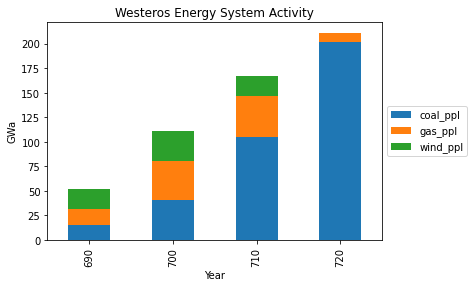

In [31]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Capacity

How much capacity of each plant is installed in each period?

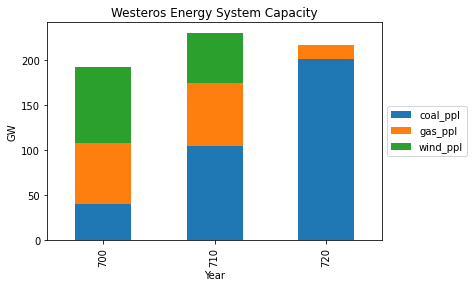

In [32]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution.
They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of
electricity), which is in fact the marginal cost of the most expensive operating generator.  

Note the price drop when the most expensive technology is no longer in the system.

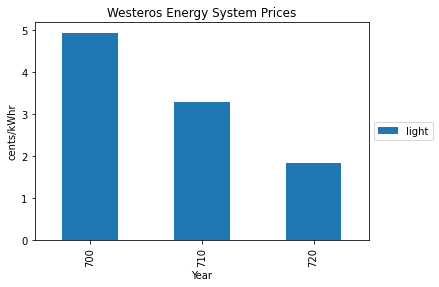

In [33]:
p.plot_prices(subset=['light'], baseyear=True)

In [34]:
mp.close_db()